In [4]:
import tarfile
import torch
import os
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms as T
from pycocotools import mask as mask_util
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.models import detection
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import misc as misc_nn_ops
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models import mobilenet_v2
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from collections import defaultdict
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from torchvision.ops import nms
import skimage.io as sio
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm.auto import tqdm

# Handle the dataset

### extract the compressed data

In [ ]:
# Extract the .tar.gz file
with tarfile.open('hw3-data-release.tar.gz', 'r:gz') as archive:
    archive.extractall()  # The folder where the contents will be extracted

### load data

In [5]:
root = "./hw3-data-release/train"
all_samples = [d for d in os.listdir(root)
               if os.path.isdir(os.path.join(root, d))]
print("Number of samples:", len(all_samples))

train_samples, val_samples = train_test_split(
    all_samples, test_size=0.2, random_state=68
)

# image_id mapping
train_id_map = {name: idx for idx, name in enumerate(train_samples)}
val_id_map = {name: idx for idx, name in enumerate(val_samples)}

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


class CellDataset(Dataset):
    def __init__(self, root_dir, sample_ids, image_id_mapping,
                 transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.samples = sample_ids
        self.image_id_mapping = image_id_mapping

    def __getitem__(self, idx):
        folder = self.samples[idx]
        folder_path = os.path.join(self.root_dir, folder)
        # 1) Load image
        image_path = os.path.join(folder_path, "image.tif")
        img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise FileNotFoundError(f"image.tif not found in {folder_path}")
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(img)

        # 2) Read all instance masks
        masks, labels = [], []
        for cls in range(1, 5):
            mask_path = os.path.join(folder_path, f"class{cls}.tif")
            if os.path.exists(mask_path):
                seg = sio.imread(mask_path)
                for inst_id in np.unique(seg)[1:]:
                    masks.append((seg == inst_id).astype(np.uint8))
                    labels.append(cls)

        H, W = image.height, image.width

        # 3) If no masks at all, make a dummy one
        if len(masks) == 0:
            print(f"Warning: No masks found in {folder_path}.Use dummy mask")
            masks = np.zeros((1, H, W), dtype=np.uint8)
            labels = [0]
        masks = torch.tensor(np.stack(masks), dtype=torch.uint8)
        labels = torch.tensor(labels, dtype=torch.int64)

        # 4) Compute boxes via NumPy for each non-empty mask
        boxes_np, keep_idxs = [], []
        masks_np = masks.cpu().numpy()
        for i, m_np in enumerate(masks_np):
            ys, xs = np.where(m_np)
            if ys.size == 0:
                continue
            xmin, ymin = int(xs.min()), int(ys.min())
            xmax, ymax = int(xs.max()), int(ys.max())
            boxes_np.append([xmin, ymin, xmax, ymax])
            keep_idxs.append(i)

        # 5) If we filtered out everything, insert a tiny dummy box
        if len(boxes_np) == 0:
            print(f"Warning: No masks found in {folder_path}. Use dummy box")
            boxes = torch.tensor([[0.0, 0.0, 1.0, 1.0]], dtype=torch.float32)
            labels = torch.tensor([0], dtype=torch.int64)
            masks = torch.zeros((1, H, W), dtype=torch.uint8)
        else:
            boxes = torch.tensor(boxes_np, dtype=torch.float32)
            labels = labels[keep_idxs]
            masks = masks[keep_idxs]

        # 6) Build target
        image_id = torch.tensor([self.image_id_mapping[folder]])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # 7) Apply transforms then to_tensor
        if self.transforms:
            image, target = self.transforms(image, target)
        else:
            image = F.to_tensor(image)
        return image, target

    def __len__(self):
        return len(self.samples)


def collate_fn(batch):
    return tuple(zip(*batch))


# build dataset
train_dataset = CellDataset(root, train_samples, train_id_map)
val_dataset = CellDataset(root, val_samples, val_id_map)

# get the distribution of labels
label_counts = Counter()
for i in range(len(train_dataset)):
    _, tgt = train_dataset[i]
    label_counts.update(tgt["labels"].cpu().tolist())

print("Label Counts:", label_counts)

# calculate log-balanced class weights based on the distribution
max_count = max(label_counts.values())
class_weights = {cls: np.log1p(max_count / count)
                 for cls, count in label_counts.items()}
print("Class Weights (log-balanced):", class_weights)

weights = []

# calculate weights for each sample
for i in range(len(train_dataset)):
    _, tgt = train_dataset[i]
    labs = tgt["labels"].cpu().tolist()
    w = np.mean([class_weights[lable] for lable in labs])
    weights.append(w)
sampler = WeightedRandomSampler(weights, len(weights), True)

train_loader = DataLoader(train_dataset, batch_size=8,
                          sampler=sampler, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8,
                        shuffle=False, collate_fn=collate_fn)

img, tgt = train_dataset[1]
print(tgt.keys())
print("GT image_id:", tgt["image_id"])
print("GT labels:", tgt["labels"])
print("GT boxes:", tgt["boxes"])
print("GT masks shape:", tgt["masks"].shape)

Number of samples: 209
Label Counts: Counter({2: 12804, 1: 10018, 4: 532, 3: 503})
Class Weights (log-balanced): {1: 0.8233415080770629, 2: 0.6931471805599453, 4: 3.2215789350889854, 3: 3.275455321444003}
dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
GT image_id: tensor([1])
GT labels: tensor([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

# Training

#### maskrcnn_resnet50_fpn_v2 model

In [6]:
def get_model_resnet50v2(num_classes):
    model = detection.maskrcnn_resnet50_fpn_v2(pretrained=True)

    # freeze the first layer of the backbone
    '''
    for param in model.backbone.body.conv1.parameters():
        param.requires_grad = False
    for param in model.backbone.body.bn1.parameters():
        param.requires_grad = False
    '''

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    model.rpn.anchor_generator.sizes = [[8, 16, 32, 64, 128]]
    model.rpn.anchor_generator.aspect_ratios = [[0.5, 1.0, 2.0]]
    # model.rpn.pre_nms_top_n_train   = 3000
    # model.rpn.post_nms_top_n_train  = 3000
    # model.rpn.pre_nms_top_n_test    = 2000
    # model.rpn.post_nms_top_n_test   = 2000
    model.rpn.nms_thresh = 0.6

    print(model.roi_heads.box_predictor.cls_score.out_features)
    return model

#### maskrcnn with mobilenet_v2 backbone

In [ ]:
def get_model_mobilenet_v2(num_classes):
    # Load pretrained MobileNetV2 backbone
    backbone = mobilenet_v2(
        pretrained=True,
        norm_layer=misc_nn_ops.FrozenBatchNorm2d).features

    # Choose layers to extract for FPN (based on MobileNetV2 structure)
    return_layers = {
        '4': '0',   # low level
        '7': '1',   # mid level
        '14': '2',  # higher level
        '18': '3'   # final conv
    }
    in_channels_list = [32, 64, 160, 1280]
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    # Wrap with FPN
    backbone_with_fpn = BackboneWithFPN(
        backbone,
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=256
    )

    # Create Mask R-CNN
    model = MaskRCNN(backbone_with_fpn, num_classes=num_classes)

    # Customize anchors if needed
    model.rpn.anchor_generator.sizes = [[8, 16, 32, 64, 128]]
    model.rpn.anchor_generator.aspect_ratios = [[0.5, 1.0, 2.0]]

    print(model.roi_heads.box_predictor.cls_score.out_features)
    return model

#### maskrcnn with resnext50_32x4d backbone

In [ ]:
def get_model_resnext50_32x4d(num_classes):
    # 建立帶有 FPN 的 resnet101 backbone
    backbone = resnet_fpn_backbone('resnext50_32x4d', pretrained=True)

    # 建立 Mask R-CNN 模型，使用自定義 backbone
    model = MaskRCNN(backbone, num_classes=num_classes)

    # change ROI predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )

    # change mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    # change anchor sizes and aspect ratios
    model.rpn.anchor_generator.sizes = [[8, 16, 32, 64, 128]]
    model.rpn.anchor_generator.aspect_ratios = [[0.5, 1.0, 2.0]]

    print(model.roi_heads.box_predictor.cls_score.out_features)
    return model

### evaluation

In [ ]:
train_losses = []
val_losses = []
train_mAPs = []
val_mAPs = []


def decode_maskobj(mask_obj):
    return mask_util.decode(mask_obj)


def encode_mask(binary_mask):
    arr = np.asfortranarray(binary_mask).astype(np.uint8)
    rle = mask_util.encode(arr)
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle


def read_maskfile(filepath):
    mask_array = sio.imread(filepath)
    return mask_array


def convert_dataset_to_coco(dataset, image_id_mapping,
                            save_path="val_gt_coco.json"):
    coco_dict = {
        "images": [],
        "annotations": [],
        "categories": [{"id": i, "name": f"class{i}"} for i in range(1, 5)]
    }
    ann_id = 1

    for idx in range(len(dataset)):
        img, target = dataset[idx]
        width, height = img.shape[2], img.shape[1]

        # get image_id from mapping
        folder_name = dataset.samples[idx]
        img_id = image_id_mapping[folder_name]

        coco_dict["images"].append({
            "id": img_id,
            "width": width,
            "height": height,
            "file_name": f"{folder_name}/image.tif"
        })

        masks = target["masks"].detach().cpu().numpy()
        labels = target["labels"].detach().cpu().numpy()

        for i in range(len(masks)):
            rle = encode_mask(masks[i])

            coco_dict["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": int(labels[i]),
                "segmentation": rle,
                "area": int(mask_util.area(rle)),
                "bbox": [float(x) for x in mask_util.toBbox(rle)],
                "iscrowd": 0
            })
            ann_id += 1
    with open(save_path, "w") as f:
        json.dump(coco_dict, f)
    print(f"Ground truth saved to {save_path}")
    return coco_dict


@torch.no_grad()
def get_coco_predictions(model, dataset, image_id_mapping,
                         device, thresh=0.05, mask_thresh=0.05,
                         save_path="val_predictions.json"):
    model.eval()
    coco_results = []

    for idx in tqdm(range(len(dataset)), desc="Generating predictions"):
        img, _ = dataset[idx]
        img = img.to(device)
        outputs = model([img])[0]

        scores = outputs["scores"].cpu()
        labels = outputs["labels"].cpu()
        masks = outputs["masks"].cpu()
        bboxes = outputs["boxes"].cpu()

        folder_name = dataset.samples[idx]
        image_id = image_id_mapping[folder_name]

        for k in range(len(scores)):

            if scores[k] < thresh:
                continue

            # use the model's box predictor
            bbox = bboxes[k].tolist()

            # optional: RLE encode the binary mask
            binary_mask = (masks[k, 0] > mask_thresh).numpy().astype(np.uint8)
            rle = encode_mask(binary_mask)

            coco_results.append({
                "image_id":    image_id,
                "category_id": int(labels[k].item()),
                "score":       float(scores[k].item()),
                "bbox":        [float(x) for x in bbox],
                "segmentation": rle
            })
    with open(save_path, "w") as f:
        json.dump(coco_results, f)
    print(f"Predictions saved to {save_path}")
    del outputs, masks, scores, labels, bboxes, img
    return coco_results


def run_coco_eval(gt_dict, predictions):
    coco_gt = COCO()
    coco_gt.dataset = gt_dict
    coco_gt.createIndex()

    coco_dt = coco_gt.loadRes(predictions)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='segm')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Print mAP
    print(f"mAP: {coco_eval.stats[0]}")
    return coco_eval.stats[0]  # mAP score


@torch.no_grad()
def evaluate_loss(model, data_loader, device):
    model.train()
    total_loss = 0.0
    for images, targets in tqdm(data_loader, desc="[Val]  Loss Eval"):
        # push到同樣 device（image_id 留在 CPU）
        images = [img.to(device) for img in images]
        targs = []
        for t in targets:
            tt = {
                k: (v.to(device)
                    if torch.is_tensor(v) and k != "image_id" else v)
                for k, v in t.items()
            }
            targs.append(tt)
        # forward + loss
        loss_dict = model(images, targs)
        loss = sum(loss_dict.values())
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss


In [ ]:
def train_one_epoch(model, optimizer, data_loader,
                    device, epoch, print_freq=10):
    model.train()
    running_loss = 0.0

    for i, (images, targets) in enumerate(
        tqdm(data_loader, desc=f"Epoch {epoch+1}")
    ):
        images = [img.to(device) for img in images]
        targets = [
            {
                k: (v.to(device) if k != "image_id" else v)
                if torch.is_tensor(v) else v
                for k, v in t.items()
            }
            for t in targets
            ]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        '''
        if i % print_freq == 0:
            print(f"  Iter {i:04d} | Loss: {losses.item():.4f}")
        '''
    avg_loss = running_loss / len(data_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} finished. Avg loss: {avg_loss:.4f}")
    return avg_loss

### train the model

In [ ]:
model = get_model_resnet50v2(num_classes=5)

params = [p for p in model.parameters() if p.requires_grad]
print(f"Number of parameters: {sum(p.numel() for p in params)}")
model.to(device)

optimizer = torch.optim.AdamW(params, lr=0.0004)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3, gamma=0.1)
gt_coco_dict_train = convert_dataset_to_coco(train_dataset, train_id_map)
gt_coco_dict_val = convert_dataset_to_coco(val_dataset, val_id_map)
num_epochs = 30
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # calculate the average loss of validation set
    val_loss = evaluate_loss(model, val_loader, device)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1} finished. Validation loss: {val_loss:.4f}")

    # evaluate on training set
    predictions = get_coco_predictions(model, train_dataset, train_id_map,
                                       device, thresh=0.05, mask_thresh=0.5)
    mAP = run_coco_eval(gt_coco_dict_train, predictions)
    train_mAPs.append(mAP)

    # evaluate on validation set
    predictions = get_coco_predictions(model, val_dataset, val_id_map, device,
                                       thresh=0.05, mask_thresh=0.5)
    mAP = run_coco_eval(gt_coco_dict_val, predictions)
    val_mAPs.append(mAP)

    del predictions
    # torch.cuda.empty_cache()

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")


### Plot learning curve

Training Losses: [1.5006787890479678, 1.5570014374596732, 0.9594354657899766, 0.7641130203292483, 0.6356911999838692, 0.5519758718354362, 0.5018857022126516, 0.49850613588378545, 0.4862198858034043, 0.4296608411130451, 0.4694623734269823, 0.47666145648275104, 0.47669080467451186, 0.46469955359186443, 0.4834908913998377, 0.5068242266064599, 0.46828335381689523, 0.44260635262443904, 0.4960039910816011, 0.46163903389658245, 0.46916075831367854, 0.5033420565582457, 0.4500668332690284]
Validation Losses: [1.361622949441274, 1.6666253010431926, 1.3521609505017598, 1.266617586215337, 1.1232421497503917, 1.1670665244261424, 1.2102831701437633, 1.1740917762120564, 1.1917561789353688, 1.17470779021581, 1.189963549375534, 1.1900258262952168, 1.18337016304334, 1.1844842533270519, 1.174848606189092, 1.1918530960877736, 1.179925759633382, 1.1973767479260762, 1.1906524896621704, 1.2027837038040161, 1.22175328930219, 1.173805058002472, 1.202323168516159]


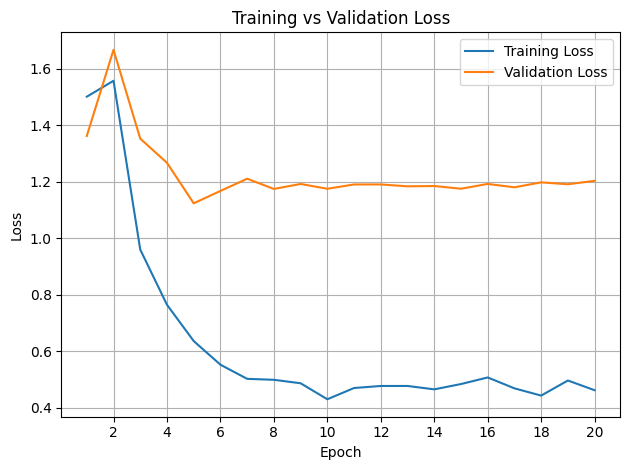

In [ ]:
epochs = list(range(1, 21))

plt.figure()
plt.plot(epochs, train_losses[:20], label='Training Loss')
plt.plot(epochs, val_losses[:20], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.xticks(ticks=range(2, 21, 2))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


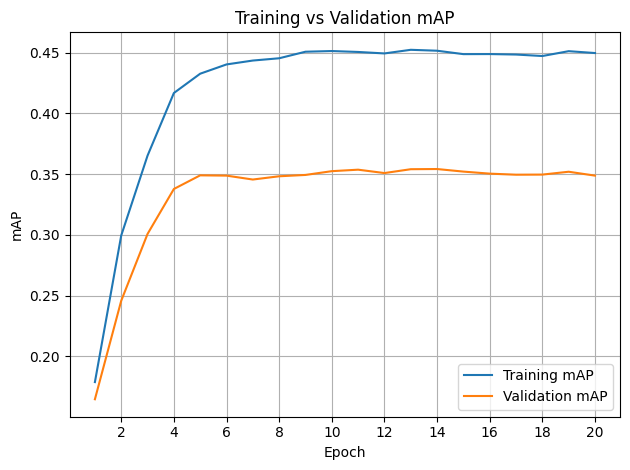

In [ ]:
epochs = list(range(1, 21))

plt.figure()
plt.plot(epochs, train_mAPs[:20], label='Training mAP')
plt.plot(epochs, val_mAPs[:20], label='Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Training vs Validation mAP')
plt.xticks(ticks=range(2, 21, 2))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing

In [ ]:
def infer_test_dataset(
    model,
    test_dir: str,
    mapping_json: str,
    device: torch.device,
    save_path: str = "test-results.json",
    score_thresh: float = 0.1,
    mask_thresh: float = 0.3
):
    # reading mapping file
    with open(mapping_json, "r") as f:
        mapping = json.load(f)

    transform = T.Compose([T.ToTensor()])

    model.eval()
    results = []

    # predict for each image
    for entry in tqdm(mapping, desc="Inferring test set"):
        fname = entry["file_name"]
        img_id = entry["id"]
        img_path = os.path.join(test_dir, fname)

        # load BGR -> RGB -> Tensor
        img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise FileNotFoundError(f"Cannot load {img_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_tensor = transform(img_rgb).to(device)

        # forward
        with torch.no_grad():
            out = model([img_tensor])[0]

        scores = out["scores"].cpu()
        labels = out["labels"].cpu()
        boxes = out["boxes"].cpu()
        masks = out["masks"].cpu()

        # only keep the predictions with score > score_thresh
        keep = scores >= score_thresh
        scores = scores[keep]
        labels = labels[keep]
        boxes = boxes[keep]
        masks = masks[keep]

        for s, lbl, box, m in zip(scores, labels, boxes, masks):
            # binary mask → RLE
            binary_mask = (m[0] > mask_thresh).numpy().astype(np.uint8)
            rle = mask_util.encode(np.asfortranarray(binary_mask))
            rle["counts"] = rle["counts"].decode("utf-8")

            # COCO format: [x, y, w, h]
            x0, y0, x1, y1 = box.tolist()
            w = x1 - x0
            h = y1 - y0

            results.append({
                "image_id":    int(img_id),
                "category_id": int(lbl.item()),
                "score":       float(s.item()),
                "bbox":        [float(x0), float(y0), float(w), float(h)],
                "segmentation": {
                    "size":   rle["size"],
                    "counts": rle["counts"]
                }
            })

    # save results to JSON
    with open(save_path, "w") as f:
        json.dump(results, f)
    print(f"Test predictions saved to {save_path}")
    return results


if __name__ == "__main__":
    model = get_model_resnet50v2(num_classes=5)
    path = (
        "./checkpoint/v2_bs=8_alldata_5[]_"
        "preposttrain=3000_epoch=10_0.448.pth"
    )

    model.load_state_dict(torch.load(path))
    model.to(device)

    infer_test_dataset(
        model,
        test_dir="./hw3-data-release/test_release",
        mapping_json="./hw3-data-release/test_image_name_to_ids.json",
        device=device,
        save_path="test-results.json",
        score_thresh=0.05,
        mask_thresh=0.5
    )


# Ensemble

In [ ]:
def load_all_preds(json_paths):
    all_preds = []
    for p in json_paths:
        all_preds.extend(json.load(open(p, 'r')))
    return all_preds


def ensemble_preds(
    all_preds,
    iou_threshold=0.5,
    score_threshold=0.05
):
    final = []
    # group by (image_id, category_id)
    groups = defaultdict(list)
    for det in all_preds:
        if det["score"] < score_threshold:
            continue
        key = (det["image_id"], det["category_id"])
        groups[key].append(det)

    for (img_id, cat_id), detections in groups.items():
        # prepare tensor for NMS
        boxes = torch.tensor([d["bbox"] for d in detections],
                             dtype=torch.float32)
        # torchvision expects [x0,y0,x1,y1]
        # our bbox is [x,y,w,h] → x1=x+w, y1=y+h
        boxes_xyxy = boxes.clone()
        boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3]
        scores = torch.tensor([d["score"] for d in detections])

        keep = nms(boxes_xyxy, scores, iou_threshold)
        for idx in keep.tolist():
            d = detections[idx]
            final.append(d)
    return final


def save_preds(preds, save_path):
    with open(save_path, 'w') as f:
        json.dump(preds, f)
    print(f"Ensemble predictions saved to {save_path}")


# list all json files needed for ensemble
json_dir = "./predictions"
json_paths = [
    os.path.join(json_dir, fn)
    for fn in os.listdir(json_dir) if fn.endswith(".json")
]

# load all .json files
all_preds = load_all_preds(json_paths)
print(f"Loaded {len(all_preds)} total detections")

# doing Ensemble
ensembled = ensemble_preds(
    all_preds,
    iou_threshold=0.5,
    score_threshold=0.05
)
print(f"{len(ensembled)} detections after NMS")

# save the final predictions
save_preds(ensembled, "test-results.json")
